In [0]:
# This code helps me learn about autoencoders and latent representations in a fun way!



In [0]:
# Imports
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [0]:
# Import the data set

(X_train, Y_train), (X_valid, Y_valid) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize
X_train , X_valid = X_train / 255.0 , X_valid / 255.0

In [0]:
# Declare the model


def build_model(input_shape):

  stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[input_shape, input_shape]),
    keras.layers.Dense(100, activation='selu'), # We use the Scaled Exponential Linear Unit (SELUs). These have the ability to self-normalize.
    keras.layers.Dense(30, activation='selu')
  ])

  stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape =[30]), # The input of the decoder is the last layer of endcoder
    keras.layers.Dense(input_shape * input_shape, activation='sigmoid'),
    keras.layers.Reshape([input_shape , input_shape])
  ])

  stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder]) #Stack encoder, decoder
  stacked_ae.compile(loss='binary_crossentropy' , optimizer=keras.optimizers.SGD(learning_rate=1.5))

  return stacked_ae , stacked_encoder , stacked_decoder

In [0]:
input_shape = X_train.shape[1] # Assume X_train dims are (m,s,s)
auto_encoder , stacked_encoder, stacked_decoder = build_model(input_shape)
history = auto_encoder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.3342 - val_loss: 0.3176
Epoch 2/10
60000/60000 [==============================] - 6s 94us/step - loss: 0.3031 - val_loss: 0.3032
Epoch 3/10
60000/60000 [==============================] - 6s 94us/step - loss: 0.2966 - val_loss: 0.2953
Epoch 4/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.2927 - val_loss: 0.2991
Epoch 5/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.2900 - val_loss: 0.2910
Epoch 6/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.2880 - val_loss: 0.2887
Epoch 7/10
60000/60000 [==============================] - 6s 95us/step - loss: 0.2867 - val_loss: 0.2874
Epoch 8/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.2855 - val_loss: 0.2875
Epoch 9/10
60000/60000 [==============================] - 6s 92us/step - loss: 0.2846 - val_loss: 0.2858
Epoch

In [0]:
def plot_image(image):
  plt.imshow(image, cmap="binary")
  plt.axis("off")


def show_reconstructions(model, n_images = 5, title = ''):
  reconstructions = model.predict(X_valid[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5 , 3))
  fig.suptitle(title , fontsize=16)




  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(X_valid[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])



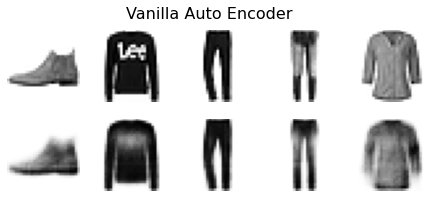

In [0]:

show_reconstructions(auto_encoder, title='Vanilla Auto Encoder')

In [0]:
# Use the t-distributed stochastic neighbor embedding algorithm to reduce the
# dimensions of the data down to 2. We do this by using the encoder latent
# representations

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

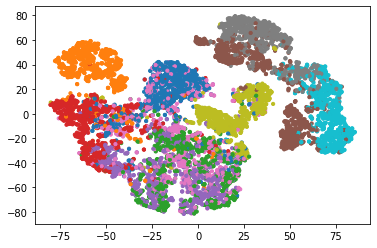

In [0]:
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=Y_valid , s=10, cmap="tab10")

In [0]:
# You can tie weights such that the decoder layer weight matrix is the transpose of 
# the corresponding encoder layer weight matrix

# Custom Layer

class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", initializer="zeros",
    shape=[self.dense.input_shape[-1]])
    super().build(batch_input_shape)
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

In [0]:

def tied_auto_encoder(input_shape):

  inputs = keras.Input(shape=[input_shape,input_shape])

  dense_1 = keras.layers.Dense(100, activation="selu")
  dense_2 = keras.layers.Dense(30, activation="selu")

  x = keras.layers.Flatten()(inputs)
  x = dense_1(x)
  x = dense_2(x)

  x = DenseTranspose(dense_2 , activation="relu")(x)
  x = DenseTranspose(dense_1, activation="sigmoid")(x)

  outputs = keras.layers.Reshape([input_shape,input_shape])(x)

  tied_ae = keras.Model(inputs=inputs, outputs=outputs)
  tied_ae.compile(loss='binary_crossentropy' , optimizer=keras.optimizers.SGD(learning_rate=1.5))

  return tied_ae


In [0]:
input_shape = X_train.shape[1] # Assume X_train dims are (m,s,s)
tied_ae = tied_auto_encoder(28)
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3273 - val_loss: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2992 - val_loss: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2926 - val_loss: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2892 - val_loss: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2870 - val_loss: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2855 - val_loss: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2842 - val_loss: 0.0000e+00
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2833 - val_loss: 0.0000e+00
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2827 - val_loss: 0.0000e+00
Epoch 10/10
1875/1875 [=======================

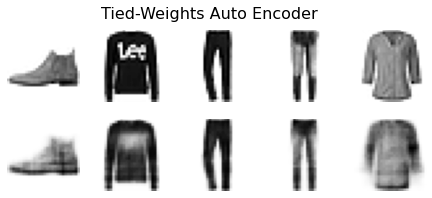

In [0]:
show_reconstructions(tied_ae, title='Tied-Weights Auto Encoder 10 Epochs')

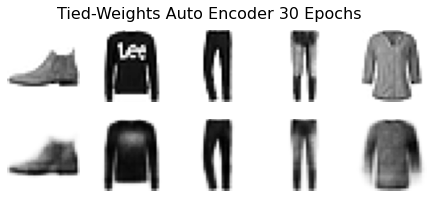

In [0]:
# Effects of Increasing the Number of Epochs

history = tied_ae.fit(X_train, X_train, epochs=30, validation_data=[X_valid, X_valid], verbose=0)
show_reconstructions(tied_ae, title='Tied-Weights Auto Encoder 30 Epochs')



In [0]:
# Convolutional Autoencoder

def conv_autoencoder(input_shape):

  conv_encoder = keras.models.Sequential([
  keras.layers.Reshape([input_shape, input_shape, 1], input_shape=[input_shape, input_shape]),
  keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
  keras.layers.MaxPool2D(pool_size=2),
  keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
  keras.layers.MaxPool2D(pool_size=2),
  keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
  keras.layers.MaxPool2D(pool_size=2)
  ])
  conv_decoder = keras.models.Sequential([
  keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",
  activation="selu",
  input_shape=[3, 3, 64]),
  keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",
  activation="selu"),
  keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
  activation="sigmoid"),
  keras.layers.Reshape([input_shape, input_shape])
  ])

  conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
  conv_ae.compile(loss='binary_crossentropy' , optimizer=keras.optimizers.SGD(learning_rate=1.5))

  return conv_ae , conv_encoder, conv_decoder






In [0]:
conv_ae , conv_encoder, conv_decoder = conv_autoencoder(28)
history = conv_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Epoch 1/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.2965 - val_loss: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2731 - val_loss: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.2686 - val_loss: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.2662 - val_loss: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2646 - val_loss: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.2633 - val_loss: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2624 - val_loss: 0.0000e+00
Epoch 8/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2616 - val_loss: 0.0000e+00
Epoch 9/10
1875/1875 [==============================] - 59s 32ms/step - loss: 0.2610 - val_loss: 0.0000e+00
Epoch 10/10
1875/1875 [=====

(10000, 28, 28)


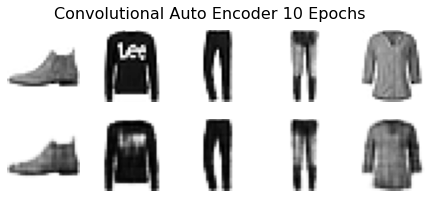

In [0]:
X_valid = X_valid.squeeze()
show_reconstructions(conv_ae, title='Convolutional Auto Encoder 10 Epochs')


In [0]:
# Recurrent Autoencoders


def rnn_autoencoder(input_shape):

  inputs = keras.Input(shape=[input_shape,input_shape])

  recurrent_1 = keras.layers.LSTM(100, return_sequences=True, input_shape=[None, input_shape]) #A sequence of any length with dimensions 28 (i.e. 28 columns)
  recurrent_2 = keras.layers.LSTM(30)

  # We use the row of the image at each time step. That's why we have a repeat 
  # vector layer.
  repeat_vector = keras.layers.RepeatVector(input_shape, input_shape=[30])
  recurrent_3 = keras.layers.LSTM(100, return_sequences=True)
  recurrent_4 = keras.layers.TimeDistributed(keras.layers.Dense(input_shape, activation="sigmoid"))


  x = recurrent_1(inputs)
  x = recurrent_2(x)


  x = repeat_vector(x)
  x = recurrent_3(x)
  x = recurrent_4(x)

  outputs = keras.layers.Reshape([input_shape,input_shape])(x)

  rnn_ae = keras.Model(inputs=inputs, outputs=outputs)
  rnn_ae.compile(loss='binary_crossentropy' , optimizer=keras.optimizers.SGD(learning_rate=1.5))

  return rnn_ae





In [0]:
rnn_ae = rnn_autoencoder(28)
history = rnn_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])


Epoch 1/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3645 - val_loss: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3166 - val_loss: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3072 - val_loss: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3016 - val_loss: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2978 - val_loss: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2948 - val_loss: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2925 - val_loss: 0.0000e+00
Epoch 8/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2905 - val_loss: 0.0000e+00
Epoch 9/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2887 - val_loss: 0.0000e+00
Epoch 10/10
1875/1875 [==============

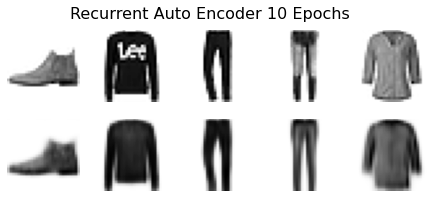

In [0]:
show_reconstructions(rnn_ae, title='Recurrent Auto Encoder 10 Epochs')